# Fase 1: Clasificación del movimiento

**Descripción**\
En esta fase, se desarrollarán y evaluarán modelos de Machine Learning con el objetivo de predecir el gesto que está realizando un paciente.
* Creación de Modelos: implementación y entrenamiento de modelos de clasificación para reconocer el tipo de gesto realizado por el paciente.
* Evaluación de Modelos: evaluación del rendimiento de los modelos entrenados utilizando métricas específicas y disintas gráficas.

**Entrada**
* ``medidasPerRepetition.csv``: archivo en formato CSV que contiene cálculos estadísticos sobre los ángulos por repetición de cada sujeto. Este es el archivo de salida de *leer_dataset.ipynb*.

**Salida**
* ``modelo_fase1.sav``: archivo que guarda el pipeline completo de clasificación entrenado, incluyendo tanto el preprocesamiento como el modelo final.

**Índice**
1. [Preprocesado](#1-preprocesado)
    - [Codificar variables](#11-codificar-variables)
    - [Dividir el dataset](#12-dividir-el-dataset)
2. [Modelos de ML](#2-modelos-de-ml)
    - [Funciones creadas](#21-funciones-creadas)
    - [Modelos con parámetros por defecto](#22-modelos-con-parámetros-por-defecto)
    - [Hiperparametrización](#23-hipermetrización)
    - [Selección de variables](#24-selección-de-variables)
3. [Evaluación de los modelos](#3-evaluación-de-los-modelos)

******

In [1]:
# ---------- importar librerías---------
# Manipular los datos
import pandas as pd
import numpy as np

# Gráficas
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('ggplot')
sns.set_theme(style="darkgrid")

# scikit-learn (ML en python)
## Procesar el dataset
from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import LeaveOneGroupOut
## Modelos ML
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
## Evaluación de los modelos
from sklearn.metrics import *
from sklearn.model_selection import cross_val_score, LearningCurveDisplay
## Hiperparametrizacion
from sklearn.model_selection import GridSearchCV,RandomizedSearchCV

## Seleccion de variables
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import RFECV

#Pipeline
from imblearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn import set_config

# Guardar modelos
import joblib

# Para ignorar los FutureWarning
import warnings
warnings.simplefilter(action = 'ignore', category = FutureWarning)

In [2]:
#---------Importar los datos-----------
# Dataframe medidas calculadas por repetición
df = pd.read_csv('../Resultados/medidasPerRepetition.csv', dtype=object) # salida de leer_dataset.ipynb
df.drop(['CorrectLabel'], axis=1,
             inplace=True)
df.head() # visualizacion de la cabecera

,SubjectID,GestureLabel,GestureName,RepetitionNumber,Position,Duration,LeftArmAngle_standardDeviation,AnkleAngleLeft_standardDeviation,HipAngleRight_standardDeviation,AnkleAngleRight_standardDeviation,...,ElbowAngleLeft_Kurtosis,HipAngleLeft_Kurtosis,KneeAngleLeft_Kurtosis,WristAngleRight_Kurtosis,WristAngleLeft_Kurtosis,ShoulderAngleRight_Kurtosis,KneeAngleRight_Kurtosis,ElbowAngleRight_Kurtosis,RightArmAngle_Kurtosis,ShoulderAngleLeft_Kurtosis
0,102,0,EFL,1,stand,74,0.33017408465525655,0.480105616697462,0.3063581511814836,1.7357630825345078,...,0.0031651605219784607,0.1950860066202451,-0.16696522726578022,0.375606810920206,0.49064396646617325,-0.005024522767072437,-0.15931125809206037,-1.4904572038164694,0.22147301566722177,-1.2511436779592484
1,102,0,EFL,2,stand,64,0.8432297182714664,0.4776724907988188,0.2752282296825027,2.5199308063586257,...,-0.37276591142763404,-0.7888113108681654,-1.05513197100136,1.1543998957163382,-0.4820511677254036,-0.6576579439512305,-0.7952358950848302,-1.431169382708514,-1.4860333958071466,-0.472467253988782
2,102,0,EFL,3,stand,58,0.44523810764335015,0.47012375323189487,0.2968562465955533,0.8997987242880856,...,-0.7468858689852,-0.9158241443474404,-1.142127903113062,9.59080204890984,-0.4600530042376674,-0.564910069837087,-0.6294624577289896,-1.4481284878299678,-0.7913285454951731,-0.80871088359656
3,102,0,EFL,4,stand,60,0.6124791156739234,0.47818097901976947,0.2897218836846879,1.140918640565108,...,-0.43473169212731255,-1.1852260550732128,-1.2227381742521826,4.1336237058292,-0.8802435890745861,0.12170810583775316,-0.8623099615734113,-1.5858806918810486,0.2021513530164274,-1.177012012109949
4,102,0,EFL,5,stand,63,0.5358728590522951,0.43803672306642194,0.18288000709507443,1.9153757520588566,...,-0.6246555005572025,-0.5924323757251706,0.01031777600595607,5.640903309376775,0.24772473501311465,0.2395354931475424,-0.7211398634607731,-1.4608887020665993,0.8374033797172151,-0.6891877979451944


****

## 1. Preprocesado

### 1.1 Codificar variables

In [3]:
# ------Preparar el dataset-------
df["Position"] = df["Position"].astype(str)

encoder = OrdinalEncoder()
encoder.fit(df[["Position"]])
df["Position"] = encoder.transform(df[["Position"]])

df = df.drop(['GestureName'], axis=1)

# pasar variable obj to numeric
df = df.apply(pd.to_numeric, errors='ignore')

df.head()

,SubjectID,GestureLabel,RepetitionNumber,Position,Duration,LeftArmAngle_standardDeviation,AnkleAngleLeft_standardDeviation,HipAngleRight_standardDeviation,AnkleAngleRight_standardDeviation,ArmsTogetherAngle_standardDeviation,...,ElbowAngleLeft_Kurtosis,HipAngleLeft_Kurtosis,KneeAngleLeft_Kurtosis,WristAngleRight_Kurtosis,WristAngleLeft_Kurtosis,ShoulderAngleRight_Kurtosis,KneeAngleRight_Kurtosis,ElbowAngleRight_Kurtosis,RightArmAngle_Kurtosis,ShoulderAngleLeft_Kurtosis
0,102,0,1,3.0,74,0.330174,0.480106,0.306358,1.735763,0.177284,...,0.003165,0.195086,-0.166965,0.375607,0.490644,-0.005025,-0.159311,-1.490457,0.221473,-1.251144
1,102,0,2,3.0,64,0.843230,0.477672,0.275228,2.519931,0.426373,...,-0.372766,-0.788811,-1.055132,1.154400,-0.482051,-0.657658,-0.795236,-1.431169,-1.486033,-0.472467
2,102,0,3,3.0,58,0.445238,0.470124,0.296856,0.899799,0.304260,...,-0.746886,-0.915824,-1.142128,9.590802,-0.460053,-0.564910,-0.629462,-1.448128,-0.791329,-0.808711
3,102,0,4,3.0,60,0.612479,0.478181,0.289722,1.140919,0.399579,...,-0.434732,-1.185226,-1.222738,4.133624,-0.880244,0.121708,-0.862310,-1.585881,0.202151,-1.177012
4,102,0,5,3.0,63,0.535873,0.438037,0.182880,1.915376,0.279638,...,-0.624656,-0.592432,0.010318,5.640903,0.247725,0.239535,-0.721140,-1.460889,0.837403,-0.689188


### 1.2 Dividir el dataset

In [4]:
# ---- Dividir en test y train -----------
# Selecciona los datos de prueba (varios sujetos)
test_df = df.loc[(df.SubjectID==102) | (df.SubjectID==105) | (df.SubjectID==107) | (df.SubjectID==201) |
            (df.SubjectID==202) | (df.SubjectID==205) | (df.SubjectID==211) |(df.SubjectID==301) | (df.SubjectID==302)] 

# Selecciona los datos de entrenamiento excluyendo los mismos sujetos
train_df = df.loc[(df.SubjectID!=102) & (df.SubjectID!=105) & (df.SubjectID!=107) & (df.SubjectID!=201) &
                (df.SubjectID!=202) & (df.SubjectID!=205) & (df.SubjectID!=211) & (df.SubjectID!=301) & (df.SubjectID!=302)]

# ------- Dividir en target y variables ---------
train_X = train_df.drop(['GestureLabel'], axis=1)
train_y=pd.DataFrame(train_df['GestureLabel']) 
test_X= test_df.drop(['GestureLabel'], axis=1) 
test_y =pd.DataFrame(test_df['GestureLabel'])

# Convertimos los df de target (y) a 1-d
train_y = train_y.values.ravel()
test_y = test_y.values.ravel()

*****

## 2. Modelos de ML

### 2.1 Funciones creadas

In [5]:
# Dataframe para guardar los resultados
test_result = pd.DataFrame({'Clasificadores': ['K-Neighbors',
                                            'Decision tree',
                                            'Naive Bayes',
                                            'Suport Vector Machine',
                                            'Random Forest']})

#-------Funcion para evaluar los modelos-----------
def test_models(modelos: list, tX: pd.DataFrame, ty: np.ndarray, df: pd.DataFrame, column_name: str):
   """
   Evalúa una lista de modelos usando la métrica F1-score ponderada ('weighted') y\\
   guarda los resultados en un DataFrame.

   Parámetros
   ----------
   modelos : list
      Lista de modelos a evaluar. Cada modelo debe implementar el método `.predict`.
   tX : pd.DataFrame
      Conjunto de datos de prueba con las características.
   ty : np.ndarray
      Array con los valores reales de la salida del conjunto de prueba.
   df : pd.DataFrame
      DataFrame donde se almacenarán los F1-scores resultantes.
   column_name : str
      Nombre de la columna en `df` donde se guardarán los resultados de la evaluación.
   """
   new_evaluation = []
   for modelo in modelos:
      prediction = modelo.predict(tX) #  predicciones en los datos de prueba
      report = classification_report(ty, prediction, zero_division=0) # informe de evaluación
      score = f1_score(test_y, prediction, average='weighted') 
      new_evaluation.append(score)
      print(f"\nModelo: {modelo.__class__.__name__}") 
      print(report) 
   df.loc[:, column_name] = new_evaluation

#-----------Función matriz de confusión-----
def plot_confusion_matrix(modelo, tX: pd.DataFrame, ty: np.ndarray):
    """
    Grafica la matriz de confusión para un modelo de clasificación dado.

    Parámetros
    ----------
    modelo : sklearn.base.BaseEstimator
        El modelo de clasificación entrenado. Debe implementar el método `.predict`.
    tX : pd.DataFrame
        Conjunto de datos de prueba con las características.
    ty : np.ndarray
        Array con los valores reales de la salida del conjunto de prueb
    """
    prediction = modelo.predict(tX)
    cm = confusion_matrix(ty, prediction)
    cm_df = pd.DataFrame(cm,
                     index = ['EFL','EFR','SFL', 'SFR', 'SAL',
                              'SAR', 'SFE', 'STL', 'STR'], 
                     columns = ['EFL','EFR','SFL', 'SFR', 'SAL',
                              'SAR', 'SFE', 'STL', 'STR'])
    ax = sns.heatmap(cm_df, annot=True, cmap="Blues", fmt="d")
    ax.set_title(f'Matriz de confusión {modelo.__class__.__name__}')
    ax.set_xlabel('Predicted labels')
    ax.set_ylabel('True labels')

### 2.2 Modelos con parámetros por defecto

In [6]:
#--------intanciar modelos de ML----------
knn = KNeighborsClassifier() # K-Neighbors classifier
dtree = DecisionTreeClassifier() # Decision tree
nb = GaussianNB() # Naive Bayes
svm = SVC() # Suport Vector Machine
rf = RandomForestClassifier()  # Random Forest

#--------entrenamiento de los modelos----------
models = [knn, dtree, nb, svm, rf]

for modelo in models:
    modelo.fit(train_X, train_y)

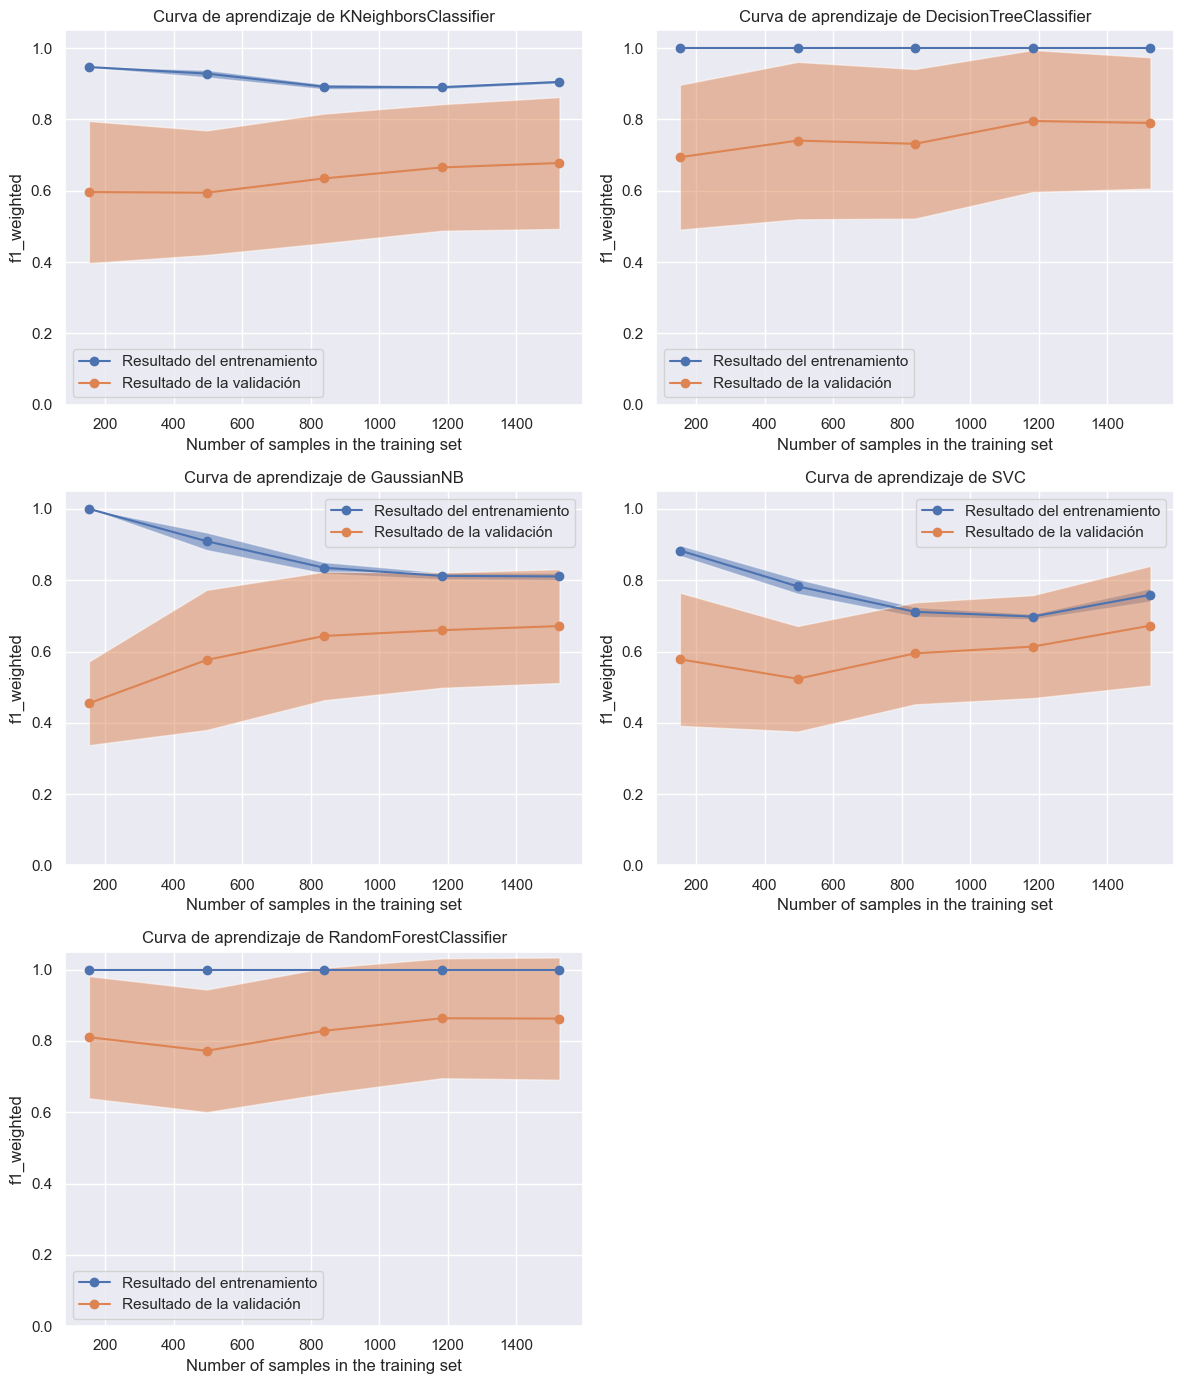

In [7]:
#---------- Curvas de apendizaje -------------
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(12, 14))

common_params = {
    "X": train_X,
    "y": train_y,
    "groups": train_X['SubjectID'],
    "cv": LeaveOneGroupOut(),
    "score_type": "both",
    "n_jobs": 4,
    "line_kw": {"marker": "o"},
    "std_display_style": "fill_between",
    "score_name": "f1_weighted",
}
for idx, estimator in enumerate(models):
    row = idx // 2
    col = idx % 2
    ax = axes[row, col]
    LearningCurveDisplay.from_estimator(estimator, **common_params, ax=ax)
    handles, label = ax.get_legend_handles_labels()
    ax.legend(handles[:2], ["Resultado del entrenamiento",
                            "Resultado de la validación"])
    ax.set_title(f"Curva de aprendizaje de {estimator.__class__.__name__}")
    ax.set_ylim(0, 1.05)
fig.delaxes(axes.flatten()[5])

plt.tight_layout()
plt.show()

In [8]:
# -------- Métricas de evaluación ---------
test_models(models, test_X, test_y, test_result, 'Modelos')


Modelo: KNeighborsClassifier
              precision    recall  f1-score   support

           0       0.76      0.91      0.83        81
           1       0.83      0.90      0.86        99
           2       0.63      0.61      0.62       113
           3       0.64      0.70      0.67        86
           4       0.73      0.48      0.58       112
           5       0.59      0.62      0.61        72
           6       0.96      0.88      0.92        76
           7       0.65      0.76      0.70        93
           8       0.74      0.70      0.72       114

    accuracy                           0.72       846
   macro avg       0.73      0.73      0.72       846
weighted avg       0.72      0.72      0.72       846


Modelo: DecisionTreeClassifier
              precision    recall  f1-score   support

           0       0.76      0.88      0.81        81
           1       0.90      0.85      0.88        99
           2       0.71      0.62      0.66       113
           3    

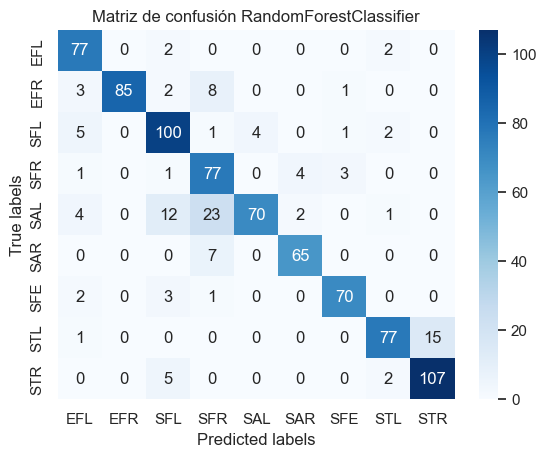

In [9]:
# ------- Matriz de confusión --------
plot_confusion_matrix(rf, test_X, test_y)

### 2.3 Hipermetrización

In [10]:
#------------- Mallas de Parametros ---------------
param_grid_knn = {
    'n_neighbors': [6, 7, 8],
    'weights': ('uniform', 'distance'),
    'leaf_size': (3, 4, 5, 6, 8),
    'p': (1,2),
    'metric': ('minkowski', 'chebyshev')
}

param_grid_dtree = {
    'criterion': ['gini', 'entropy', 'log_loss'],
    'splitter': ['best', 'random'],
    'max_depth': [None, 40, 50, 60],
    'min_samples_split': [2, 10, 20],
    'min_samples_leaf': [1, 2, 5, 7],
    'max_features': [None, 'sqrt', 'log2']
}

param_grid_nb = {'var_smoothing': np.logspace(0, -8, num=100)}


param_grid_svm = {
    'C': [0.1, 0.2, 0.3],
    'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
    'gamma': ['scale', 'auto'],
    'degree': [2, 3],
    'coef0': [0.0, 0.1, 0.2]
}

param_grid_rf = {
    'n_estimators': [300, 400, 500],
    'max_features': ['sqrt', 'log2'],
    'max_depth': [None, 50, 60],
    'min_samples_split': [2, 3, 4],
    'min_samples_leaf': [1, 2, 5, 6],
}


Modelo: KNeighborsClassifier
Mejores parámetros:  {'leaf_size': 3, 'metric': 'minkowski', 'n_neighbors': 7, 'p': 1, 'weights': 'uniform'}
Mejor resultado:  0.7406254749212933


<Figure size 600x400 with 0 Axes>

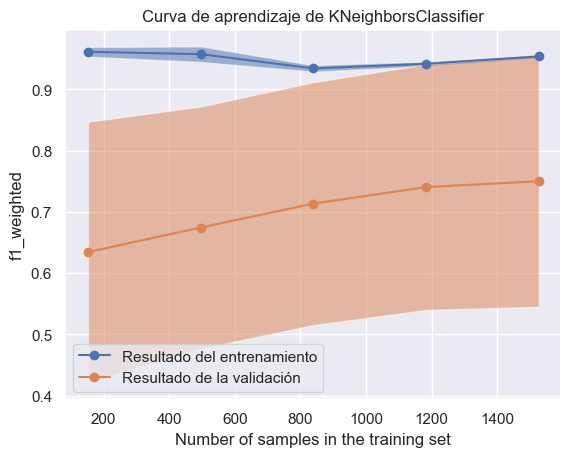


Modelo: DecisionTreeClassifier
Mejores parámetros:  {'criterion': 'log_loss', 'max_depth': 50, 'max_features': None, 'min_samples_leaf': 5, 'min_samples_split': 2, 'splitter': 'random'}
Mejor resultado:  0.8163686612801507


<Figure size 600x400 with 0 Axes>

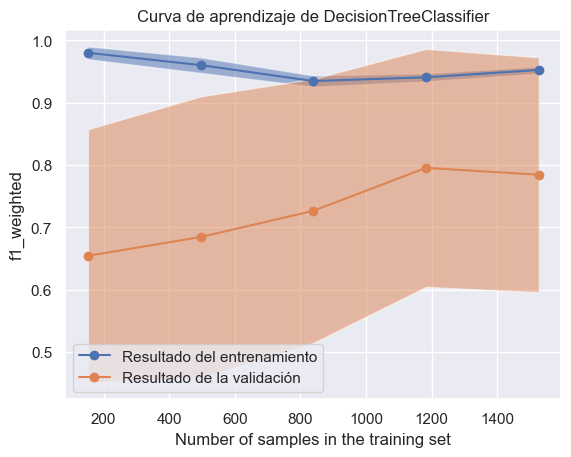


Modelo: GaussianNB
Mejores parámetros:  {'var_smoothing': 4.641588833612773e-06}
Mejor resultado:  0.6411161240081016


<Figure size 600x400 with 0 Axes>

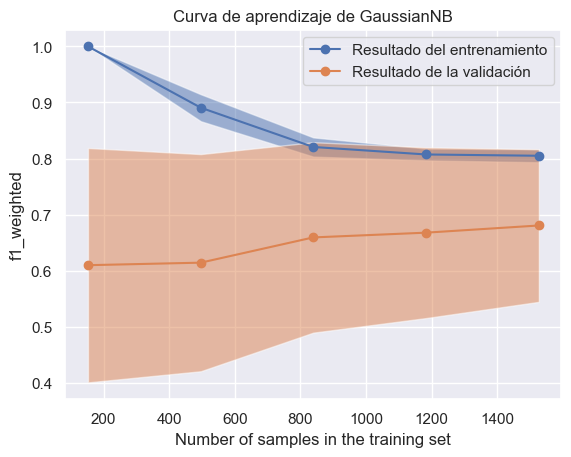


Modelo: SVC
Mejores parámetros:  {'C': 0.1, 'coef0': 0.0, 'degree': 2, 'gamma': 'scale', 'kernel': 'linear'}
Mejor resultado:  0.819576248635934


<Figure size 600x400 with 0 Axes>

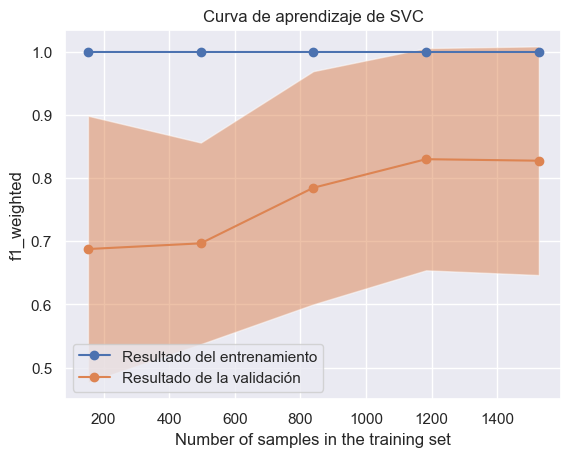


Modelo: RandomForestClassifier
Mejores parámetros:  {'max_depth': None, 'max_features': 'log2', 'min_samples_leaf': 2, 'min_samples_split': 4, 'n_estimators': 500}
Mejor resultado:  0.8567350762200947


<Figure size 600x400 with 0 Axes>

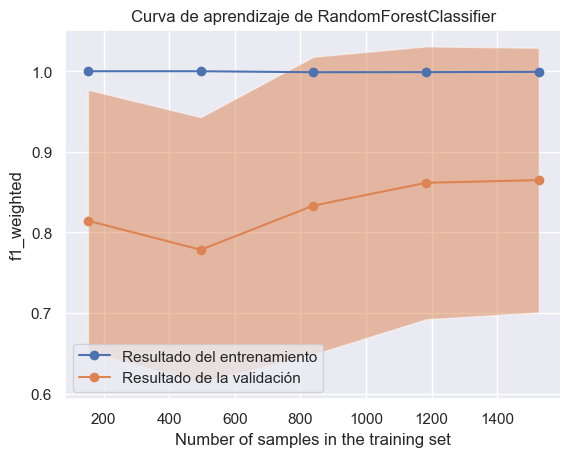

In [11]:
# ----- Aplicar hiperparametrización ---------------

# cv con LeaveOneGroupOut
logo = LeaveOneGroupOut()
subject_ids = train_X['SubjectID'] # para los grupos

# crear los modelos con GridSearchCV
gs_knn = GridSearchCV(KNeighborsClassifier(), param_grid_knn, cv=logo,
                      scoring='f1_weighted', n_jobs=-1)
gs_dtree = GridSearchCV(DecisionTreeClassifier(), param_grid_dtree, cv=logo,
                        scoring='f1_weighted', n_jobs=-1)
gs_nb = GridSearchCV(GaussianNB(), param_grid_nb, cv=logo,
                     scoring='f1_weighted', n_jobs=-1)
gs_svm = GridSearchCV(SVC(), param_grid_svm, cv=logo,
                      scoring='f1_weighted', n_jobs=-1)
gs_rf = GridSearchCV(RandomForestClassifier(), param_grid_rf, cv=logo,
                           scoring='f1_weighted', n_jobs=-1)

modelos = [gs_knn, gs_dtree, gs_nb, gs_svm, gs_rf]

best_models = []
for modelo in modelos:
    # entrenar
    modelo.fit(train_X, train_y, groups=subject_ids)
    best_modelo = modelo.best_estimator_
    # imprimir resultado
    print(f"\nModelo: {modelo.estimator.__class__.__name__}") 
    print("Mejores parámetros: ", modelo.best_params_)
    print("Mejor resultado: ", modelo.best_score_)
    best_models.append(best_modelo)
    # curvas de apendizaje
    plt.figure(figsize=(6,4))
    LearningCurveDisplay.from_estimator(best_modelo, 
                                        X=train_X,
                                        y=train_y,
                                        groups=subject_ids,
                                        cv=logo,
                                        score_type="both",
                                        n_jobs=4,
                                        line_kw={"marker": "o"},
                                        std_display_style="fill_between",
                                        score_name="f1_weighted"
                                    )
        
    plt.legend(["Resultado del entrenamiento", "Resultado de la validación"])
    plt.title(f"Curva de aprendizaje de {modelo.estimator.__class__.__name__}")
    plt.show()

In [12]:
# -------- Evaluación de los modelos --------
test_models(best_models, test_X, test_y, test_result, 'Hiperparametrización (H)')


Modelo: KNeighborsClassifier
              precision    recall  f1-score   support

           0       0.78      0.90      0.84        81
           1       0.87      0.89      0.88        99
           2       0.65      0.60      0.62       113
           3       0.64      0.76      0.69        86
           4       0.75      0.52      0.61       112
           5       0.64      0.60      0.62        72
           6       0.96      0.88      0.92        76
           7       0.61      0.98      0.76        93
           8       0.77      0.56      0.65       114

    accuracy                           0.73       846
   macro avg       0.74      0.74      0.73       846
weighted avg       0.74      0.73      0.72       846


Modelo: DecisionTreeClassifier
              precision    recall  f1-score   support

           0       0.85      0.90      0.87        81
           1       0.97      0.79      0.87        99
           2       0.64      0.81      0.71       113
           3    

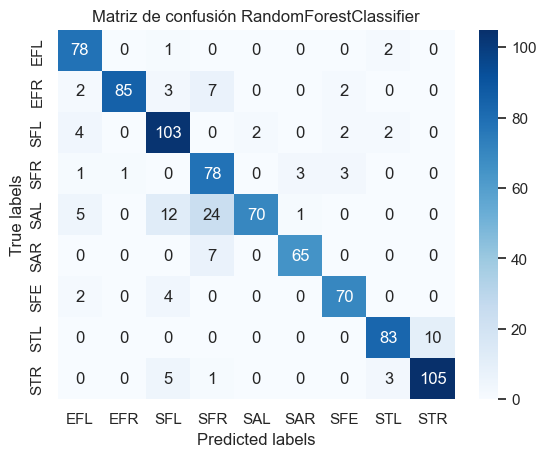

In [13]:
# --------- Matriz de confusión de RF ---------
plot_confusion_matrix(best_models[4], test_X, test_y)

### 2.4 Selección de variables

**2.4.1 SelectKBest**

Hay que tener en cunata que la columna *SubjectID* debe de estar en dataframe final para poder hacer los gurpos al realizar la validación cruzada con *LeaveOneGroupOut()*

In [14]:
subject_id = train_X['SubjectID']

# Definimos feature Selection K=50 (selecciona entonces las 50 variables que considere mas importantes)
feature_selection = SelectKBest(k=50)

# Fit Feature Selection (entrena y hace una tranformada)
selected_features = feature_selection.fit_transform(train_X.drop(columns=['SubjectID']), train_y)

# Selecionamos las características mas relevantes para nuestro problema
selected = feature_selection.get_support(indices=True)

print(train_X.columns[selected])

# Reduce train_X to the selected features with .transform(X)
# esto elimina las variales que no nos intersan.

X_fs = pd.DataFrame(selected_features,
                 columns=train_X.drop(columns=['SubjectID']).columns[selected])

X_fs['SubjectID'] = subject_id.values


Index(['Duration', 'AnkleAngleLeft_standardDeviation',
       'AnkleAngleRight_standardDeviation',
       'ArmsTogetherAngle_standardDeviation',
       'ElbowAngleLeft_standardDeviation', 'HipAngleLeft_standardDeviation',
       'WristAngleLeft_standardDeviation', 'KneeAngleRight_standardDeviation',
       'ElbowAngleRight_standardDeviation', 'RightArmAngle_standardDeviation',
       'ArmsTogetherAngle_Maximum', 'WristAngleLeft_Maximum',
       'KneeAngleRight_Maximum', 'RightArmAngle_Maximum',
       'ShoulderAngleLeft_Maximum', 'AnkleAngleRight_Minimum',
       'WristAngleLeft_Minimum', 'ElbowAngleRight_Minimum',
       'RightArmAngle_Minimum', 'ShoulderAngleLeft_Minimum',
       'AnkleAngleRight_Mean', 'WristAngleLeft_Mean', 'ElbowAngleRight_Mean',
       'RightArmAngle_Mean', 'ShoulderAngleLeft_Mean', 'AnkleAngleRight_Range',
       'ArmsTogetherAngle_Range', 'HipAngleLeft_Range', 'WristAngleLeft_Range',
       'KneeAngleRight_Range', 'ElbowAngleRight_Range', 'RightArmAngle_Range',

In [15]:
# ----- Entrenar con variables seleccionadas ----------
knn_fs = KNeighborsClassifier() # K-Neighbors classifier
dtree_fs = DecisionTreeClassifier() # Decision tree
nb_fs = GaussianNB() # Naive Bayes
svm_fs = SVC() # Suport Vector Machine
rf_fs = RandomForestClassifier()  # Random Forest

models_fs = [knn_fs, dtree_fs, nb_fs, svm_fs, rf_fs]

logo = LeaveOneGroupOut()

for modelo in models_fs:
        print(f"\nModelo: {modelo.__class__.__name__}")
        modelo.fit(X_fs, train_y)
        scores = cross_val_score(modelo, X_fs, train_y, groups=X_fs['SubjectID'], 
                                 scoring='f1_weighted', cv=logo)
        print("%0.2f F1 score con una derivación estandar de %0.2f" % (scores.mean(), scores.std()))


Modelo: KNeighborsClassifier
0.69 F1 score con una derivación estandar de 0.18

Modelo: DecisionTreeClassifier
0.78 F1 score con una derivación estandar de 0.20

Modelo: GaussianNB
0.66 F1 score con una derivación estandar de 0.16

Modelo: SVC
0.56 F1 score con una derivación estandar de 0.13

Modelo: RandomForestClassifier
0.85 F1 score con una derivación estandar de 0.18


In [16]:
# ------ Transformar el conjunto de test y evaluación -----------
test_subject_id = test_X['SubjectID']

selected_features_test = feature_selection.transform(test_X.drop(columns=['SubjectID']))

X_fs_test = pd.DataFrame(selected_features_test,
                         columns=test_X.drop(columns=['SubjectID']).columns[selected])

X_fs_test['SubjectID'] = test_subject_id.values

test_models(models_fs, X_fs_test, test_y, test_result, 'Selección de variables (FS)')


Modelo: KNeighborsClassifier
              precision    recall  f1-score   support

           0       0.77      0.93      0.84        81
           1       0.88      0.92      0.90        99
           2       0.68      0.67      0.68       113
           3       0.62      0.63      0.62        86
           4       0.60      0.50      0.55       112
           5       0.57      0.71      0.63        72
           6       0.97      0.88      0.92        76
           7       0.68      0.68      0.68        93
           8       0.71      0.63      0.67       114

    accuracy                           0.72       846
   macro avg       0.72      0.73      0.72       846
weighted avg       0.72      0.72      0.71       846


Modelo: DecisionTreeClassifier
              precision    recall  f1-score   support

           0       0.73      0.90      0.81        81
           1       0.93      0.81      0.86        99
           2       0.79      0.73      0.76       113
           3    

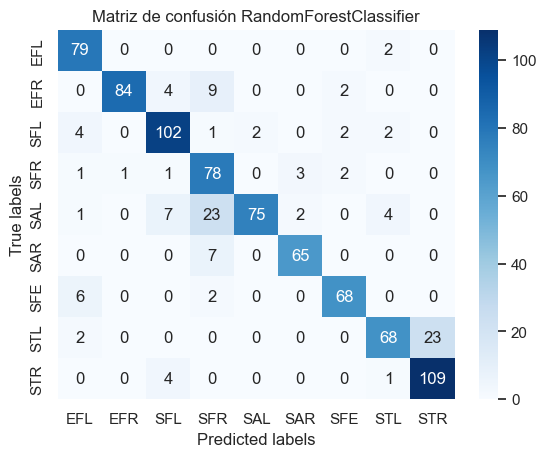

In [17]:
# --------- Matriz de confusión -------------
plot_confusion_matrix(rf_fs, X_fs_test, test_y,)

**2.4.2 Modelos con hiperparametrización y selección de variables**

Entrenar los modelos a los cuales se la ha realizado el ajuste de hiperparámetros con las variables seleccionadas anteriormente

In [18]:
# Entrenar los modelos
for modelo in best_models:
    modelo.fit(X_fs, train_y)

# Evaluación
test_models(best_models, X_fs_test, test_y, test_result, 'H + Fs')


Modelo: KNeighborsClassifier
              precision    recall  f1-score   support

           0       0.81      0.95      0.88        81
           1       0.87      0.92      0.89        99
           2       0.72      0.73      0.72       113
           3       0.72      0.73      0.73        86
           4       0.68      0.54      0.60       112
           5       0.62      0.76      0.68        72
           6       0.97      0.88      0.92        76
           7       0.79      0.74      0.77        93
           8       0.78      0.76      0.77       114

    accuracy                           0.77       846
   macro avg       0.77      0.78      0.77       846
weighted avg       0.77      0.77      0.77       846


Modelo: DecisionTreeClassifier
              precision    recall  f1-score   support

           0       0.73      0.75      0.74        81
           1       0.97      0.67      0.79        99
           2       0.73      0.90      0.81       113
           3    

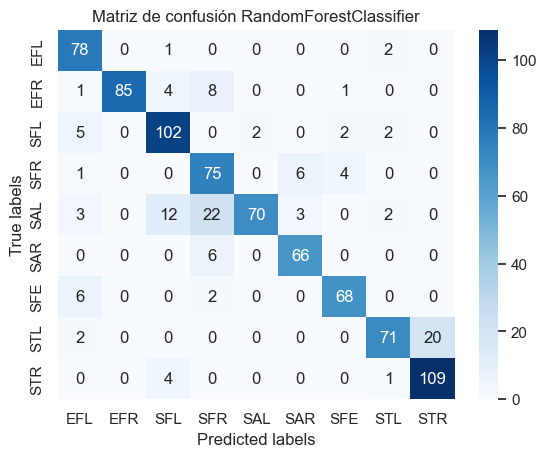

In [19]:
# ------- Matriz de confusión de RF -------------------
plot_confusion_matrix(best_models[4], X_fs_test, test_y)
mejores_parametros = best_models[4].get_params()

**2.4.3 Recursive feature elimination**

Selección de varaibles con RFECV

In [20]:
# Modelos a los que se puede aplicar RFECV
dtree_rfe = DecisionTreeClassifier() # Decision tree
rf_rfe = RandomForestClassifier(n_estimators = 5)  # Random Forest

models_with_coef = [dtree_rfe, rf_rfe]


Modelo: DecisionTreeClassifier
Número óptimo de características: 91
['SubjectID' 'RepetitionNumber' 'Position' 'Duration'
 'LeftArmAngle_standardDeviation' 'AnkleAngleLeft_standardDeviation'
 'HipAngleRight_standardDeviation' 'AnkleAngleRight_standardDeviation'
 'ArmsTogetherAngle_standardDeviation' 'ElbowAngleLeft_standardDeviation'
 'HipAngleLeft_standardDeviation' 'KneeAngleLeft_standardDeviation'
 'WristAngleRight_standardDeviation' 'WristAngleLeft_standardDeviation'
 'ShoulderAngleRight_standardDeviation' 'KneeAngleRight_standardDeviation'
 'ElbowAngleRight_standardDeviation' 'RightArmAngle_standardDeviation'
 'ShoulderAngleLeft_standardDeviation' 'LeftArmAngle_Maximum'
 'AnkleAngleLeft_Maximum' 'HipAngleRight_Maximum'
 'AnkleAngleRight_Maximum' 'ArmsTogetherAngle_Maximum'
 'ElbowAngleLeft_Maximum' 'HipAngleLeft_Maximum' 'KneeAngleLeft_Maximum'
 'WristAngleRight_Maximum' 'WristAngleLeft_Maximum'
 'ShoulderAngleRight_Maximum' 'KneeAngleRight_Maximum'
 'ElbowAngleRight_Maximum' 'Ri

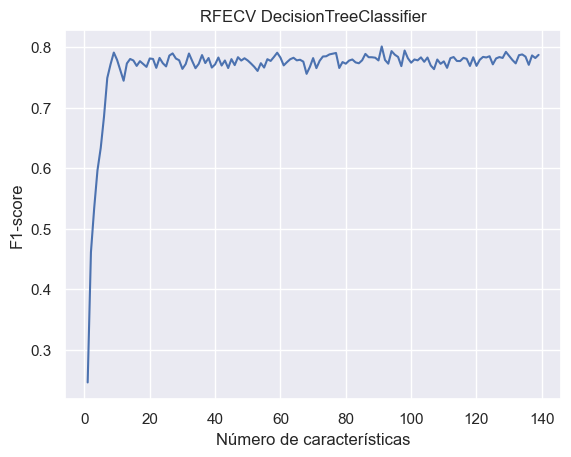


Modelo: RandomForestClassifier
Número óptimo de características: 22
['ShoulderAngleRight_standardDeviation'
 'ElbowAngleRight_standardDeviation' 'ElbowAngleLeft_Maximum'
 'HipAngleLeft_Maximum' 'ShoulderAngleRight_Maximum'
 'ElbowAngleRight_Maximum' 'ShoulderAngleLeft_Maximum'
 'LeftArmAngle_Minimum' 'RightArmAngle_Minimum' 'ElbowAngleRight_Mean'
 'RightArmAngle_Mean' 'ShoulderAngleLeft_Mean' 'ElbowAngleLeft_Range'
 'ElbowAngleRight_Range' 'ShoulderAngleLeft_Range' 'LeftArmAngle_Variance'
 'ArmsTogetherAngle_Variance' 'HipAngleLeft_Variance'
 'KneeAngleLeft_Variance' 'ShoulderAngleRight_Variance'
 'ArmsTogetherAngle_CoV' 'HipAngleLeft_CoV']
Evaluación: 0.8049645390070922


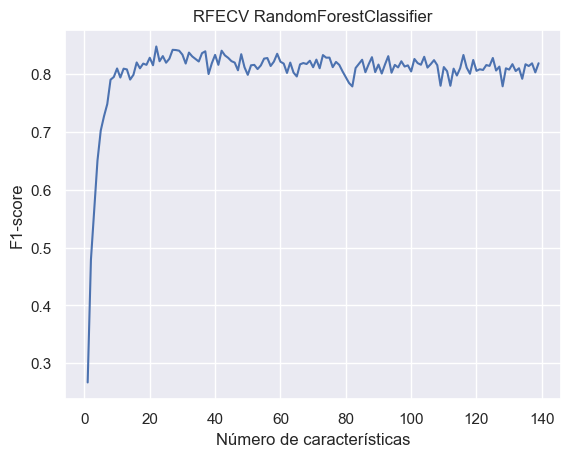

In [21]:
# ------- Aplicar RFECV ----------
for model in models_with_coef:
    rfecv = RFECV(
            estimator=model,
        scoring="f1_weighted",
        cv = LeaveOneGroupOut(),
        n_jobs=-1 
    )
    # entrenar
    rfecv.fit(train_X, train_y, groups=train_X['SubjectID'])
    # mostrar resultados
    print(f"\nModelo: {rfecv.estimator.__class__.__name__}") 
    print(f"Número óptimo de características: {rfecv.n_features_}")
    selected = rfecv.get_feature_names_out()
    print(selected)
    print(f'Evaluación: {rfecv.score(test_X, test_y)}')
    # mostrar gráfica
    cv_results = pd.DataFrame(rfecv.cv_results_)
    plt.title(f"RFECV {rfecv.estimator.__class__.__name__}")
    plt.xlabel("Número de características")
    plt.ylabel("F1-score")
    plt.plot(range(1, len(cv_results['mean_test_score']) + 1),
             cv_results['mean_test_score'])
    plt.show()

****

## 3. Evaluación de los modelos

In [22]:
#-------- Dataframe con los f1-scores ------
test_result

,Clasificadores,Modelos,Hiperparametrización (H),Selección de variables (FS),H + Fs
0,K-Neighbors,0.716240,0.723869,0.712933,0.767341
1,Decision tree,0.753899,0.795375,0.782321,0.767701
2,Naive Bayes,0.677299,0.675203,0.732557,0.731150
3,Suport Vector Machine,0.727674,0.799879,0.597243,0.805778
4,Random Forest,0.860359,0.870847,0.860516,0.854822


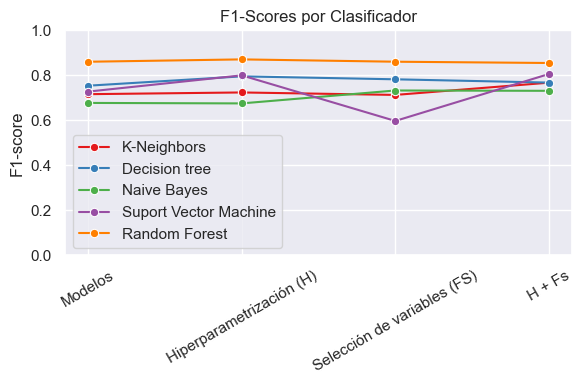

In [23]:
# ------- Gráfica comparativa -------
x_labels = ['Modelos', 'Hiperparametrización (H)', 'Selección de variables (FS)', 'H + Fs']
df_melted = pd.melt(test_result, id_vars=['Clasificadores'], value_vars=x_labels,
                    var_name='score_type', value_name='score')

plt.figure(figsize=(6, 4))
ax = sns.lineplot(x='score_type', y='score', hue='Clasificadores',
                  data=df_melted, marker='o', palette='Set1')

ax.set(xlabel=None)
plt.ylabel('F1-score')
plt.title('F1-Scores por Clasificador')
plt.ylim(0,1)
plt.legend(loc='lower left')

plt.xticks(rotation=30)
plt.grid(True)
plt.tight_layout()
plt.show()

Crear un pipeline con la codificacion de varibales, seleccion de características y el mejor modelo, y guardarlo con joblib

In [27]:

df_data = pd.read_csv('../Resultados/medidasPerRepetition.csv', dtype=object) # salida de leer_dataset.ipynb

# ------- Dividir en target y variables ---------
df_data = df_data.apply(pd.to_numeric, errors='ignore')
df_data.drop(['GestureName', 'CorrectLabel'], axis=1, inplace=True)

X = df_data.drop(['GestureLabel'], axis=1)
y = pd.DataFrame(df_data['GestureLabel']) 
# Convertimos los df de target (y) a 1-d
y = y.values.ravel()

filename = '../Resultados/modelo_fase1.sav'
pipeline = Pipeline([
                      ('preprocessing', ColumnTransformer(
                            transformers=[('encoder', OrdinalEncoder(), ['Position'])],
                            remainder='passthrough' ),
                        ),
  
                     ('feature_selection', SelectKBest(k=50)),
                     ('classifier', RandomForestClassifier(**mejores_parametros))
                    ])

pipeline.fit(X,y)
joblib.dump(pipeline, filename)

set_config(display="diagram")
pipeline

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('encoder', OrdinalEncoder(),
                                                  ['Position'])])),
                ('feature_selection', SelectKBest(k=50)),
                ('classifier',
                 RandomForestClassifier(max_features='log2', min_samples_leaf=2,
                                        min_samples_split=4,
                                        n_estimators=500))])